In [1]:
#!/usr/bin/env python3

from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.datasets import dump_svmlight_file
from sklearn import metrics
from sklearn.metrics import accuracy_score
import numpy as np
import logging
import codecs
import re
import os
from nltk.corpus import sentiwordnet as swn


def parse_dataset(fp):
    '''
    Loads the dataset .txt file with label-tweet on each line and parses the dataset.
    :param fp: filepath of dataset
    :return:
        corpus: list of tweet strings of each tweet.
        y: list of labels
    '''
    y = []
    corpus = []
    with open(fp, 'rt') as data_in:
        for line in data_in:
            if not line.lower().startswith("tweet index"):  # discard first line if it contains metadata
                line = line.rstrip()  # remove trailing whitespace
                label = int(line.split("\t")[1])
                tweet = line.split("\t")[2]
                y.append(label)
                corpus.append(tweet)

    return corpus, y


def featurize(corpus):
    '''
    Tokenizes and creates TF-IDF BoW vectors.
    :param corpus: A list of strings each string representing document.
    :return: X: A sparse csr matrix of TFIDF-weigted ngram counts.
    '''

    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True).tokenize
    vectorizer = TfidfVectorizer(strip_accents="unicode", analyzer="word", tokenizer=tokenizer, stop_words="english")
    X = vectorizer.fit_transform(corpus)
    # print(vectorizer.get_feature_names()) # to manually check if the tokens are reasonable
    return X


In [2]:
# Dataset: SemEval2018-T4-train-taskA.txt or SemEval2018-T4-train-taskB.txt
DATASET_FP1 = "./SemEval2018-Task3/datasets/train/SemEval2018-T4-train-taskA.txt"
TASK1 = "A"  # Define, A or B
DATASET_FP2 = "./SemEval2018-Task3/datasets/train/SemEval2018-T4-train-taskB.txt"
TASK2 = "B"  # Define, A or B

FNAME = './predictions-task' + TASK1 + '.txt'
PREDICTIONSFILE = open(FNAME, "w")

In [3]:
corpus, inp_y1 = parse_dataset(DATASET_FP1)
corpus_copy, inp_y2 = parse_dataset(DATASET_FP2)
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True).tokenize

In [4]:
import pandas as pd
raw_data = {'corpus' : [line for line in corpus], 'coarse_label': [line for line in inp_y1], 'fine_type': [line for line in inp_y2]}
df = pd.DataFrame(raw_data, columns=["corpus", "coarse_label", "fine_type"])

In [5]:
from sklearn.model_selection import train_test_split
# create train and validation set 
train, val = train_test_split(df, test_size=0.1)
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)

In [6]:
import torchtext
import spacy
import csv
from torchtext import data

# tokenizer function using spacy
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): 
    return [w.text.lower() for w in nlp(tweet_clean(s))]

def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text.strip()

# define the columns that we want to process and how to process
txt_field = data.Field(sequential=True, 
                       tokenize=tokenizer, 
                       include_lengths=True, 
                       use_vocab=True)
labelc_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)
labelf_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)

train_val_fields = [
    ('corpus', txt_field), # process it as text
    ('coarse_label', labelc_field), # process it as label
    ('fine_type', labelf_field) # we dont need this, so no processing
]

trainds, valds = data.TabularDataset.splits(path='./', 
                                            format='csv', 
                                            train='train.csv', 
                                            validation='val.csv', 
                                            fields=train_val_fields, 
                                            skip_header=True)

In [7]:
type(trainds)
len(trainds), len(valds)

(3450, 384)

In [8]:
trainds.fields.items()

[('corpus', <torchtext.data.field.Field at 0x11fa58250>),
 ('coarse_label', <torchtext.data.field.Field at 0x1218d7f50>),
 ('fine_type', <torchtext.data.field.Field at 0x1218d7dd0>)]

In [9]:
ex = trainds[2]
type(ex)
ex.corpus

[u'barackobama',
 u'so',
 u'that',
 u'is',
 u'what',
 u'happened',
 u'the',
 u'acorn',
 u'voter',
 u'fraud',
 u'people']

In [10]:
from pymagnitude import *
vectors = Magnitude("glove.twitter.27B.25d.magnitude")

In [11]:
vectors.query('the')

array([-1.489600e-03,  2.958700e-03,  3.146130e-02,  2.533110e-02,
       -6.396720e-02, -2.151870e-02,  2.700136e-01, -2.308060e-02,
        2.664680e-02, -4.656560e-02,  1.002020e-02,  7.585990e-02,
       -9.284841e-01,  7.042420e-02,  2.018550e-02, -7.115970e-02,
        5.714110e-02, -2.858000e-04, -1.497100e-02,  3.115210e-02,
       -1.262173e-01,  2.529300e-02,  2.752000e-02, -1.234394e-01,
       -4.572460e-02], dtype=float32)

In [12]:
from torchtext import vocab
vec = vocab.Vectors('glove.twitter.27B.100d.txt', './vector_cache/glove.twitter.27B')
#os.path.isdir('./vector_cache/glove.twitter.27B')

In [13]:
txt_field.build_vocab(trainds, valds, vectors=vec)
#txt_field.build_vocab(trainds, valds)
# build vocab for labels
labelc_field.build_vocab(trainds)
labelf_field.build_vocab(trainds)

In [14]:
print(txt_field.vocab.stoi['a'])

6


In [15]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.corpus), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [16]:
len(traindl), len(valdl)

(1150, 128)

In [17]:
batch = next(iter(traindl))
type(batch)
batch.fine_type

tensor([0, 0, 3])

In [18]:
batch.corpus

(tensor([[   18,    29,  5470],
         [  478,     8, 10727],
         [   40,     4, 10785],
         [   12,     7,    18],
         [  117,  9889,   675],
         [    5,  3598,     4],
         [  340,    69,     6],
         [11030, 11133,  2620],
         [  697,  6911,   778],
         [  381,  1966,     2],
         [   20,    96,  1058],
         [  381,    17,    41],
         [   20,   626,   250],
         [  381,    17,     5],
         [   20,  1007,   188],
         [  381,    56,   862],
         [   20,    99,    52],
         [  381,  1007,  1479],
         [   20,  9803,   632]]), tensor([19, 19, 19]))

In [19]:
batch.dataset.fields

{'coarse_label': <torchtext.data.field.Field at 0x1218d7f50>,
 'corpus': <torchtext.data.field.Field at 0x11fa58250>,
 'fine_type': <torchtext.data.field.Field at 0x1218d7dd0>}

In [20]:
txt_field.vocab.itos[0]

'<unk>'

In [21]:
txt_field.vocab.itos[1]

'<pad>'

In [22]:
def idxtosent(batch, idx):
    return ' '.join([txt_field.vocab.itos[i] for i in batch.corpus[0][:,idx].cpu().data.numpy()])

In [23]:
idxtosent(batch,2)

u'christiancalls1 serr8d shawnst51128037 that wasn t a choke hold the officer was trying to keep ericgarner from falling forward'

In [24]:
batch.__dict__

{'batch_size': 3,
 'coarse_label': tensor([0, 0, 1]),
 'corpus': (tensor([[   18,    29,  5470],
          [  478,     8, 10727],
          [   40,     4, 10785],
          [   12,     7,    18],
          [  117,  9889,   675],
          [    5,  3598,     4],
          [  340,    69,     6],
          [11030, 11133,  2620],
          [  697,  6911,   778],
          [  381,  1966,     2],
          [   20,    96,  1058],
          [  381,    17,    41],
          [   20,   626,   250],
          [  381,    17,     5],
          [   20,  1007,   188],
          [  381,    56,   862],
          [   20,    99,    52],
          [  381,  1007,  1479],
          [   20,  9803,   632]]), tensor([19, 19, 19])),
 'dataset': <torchtext.data.dataset.TabularDataset at 0x1218d7e50>,
 'fields': ['corpus', 'coarse_label', 'fine_type'],
 'fine_type': tensor([0, 0, 3]),
 'input_fields': ['corpus', 'coarse_label', 'fine_type'],
 'target_fields': []}

In [25]:
val_batch = next(iter(valdl))
val_batch.__dict__

{'batch_size': 3,
 'coarse_label': tensor([1, 1, 0]),
 'corpus': (tensor([[ 69,  33, 245],
          [ 11,  22,  99],
          [228, 493,   1]]), tensor([3, 3, 2])),
 'dataset': <torchtext.data.dataset.TabularDataset at 0x1218d7f10>,
 'fields': ['corpus', 'coarse_label', 'fine_type'],
 'fine_type': tensor([1, 1, 0]),
 'input_fields': ['corpus', 'coarse_label', 'fine_type'],
 'target_fields': []}

In [26]:
class BatchGenerator:
    def __init__(self, dl, x_field, yc_field, yf_field):
        self.dl, self.x_field, self.yc_field, self.yf_field = dl, x_field, yc_field, yf_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            yc = getattr(batch, self.yc_field)
            yf = getattr(batch, self.yf_field)
            yield (X,yc,yf)
            
train_batch_it = BatchGenerator(traindl, 'corpus', 'coarse_label', 'fine_type')
print(next(iter(train_batch_it)))

((tensor([[    3,     8, 11904],
        [   33,     4,    59],
        [  514,     7,     4],
        [    6, 12187,   177],
        [  288,  6997,   272],
        [   78,  2947,    26],
        [ 1115,  2947,   918],
        [    9,  2560,    14],
        [ 3715,  2519,   169],
        [   13,  6256,     4],
        [    6,    13,     7],
        [  211,    35,  4216],
        [12660,   128,  2061],
        [11048,  4587,  2508],
        [ 7183,  2005,  5080]]), tensor([15, 15, 15])), tensor([1, 0, 0]), tensor([1, 0, 0]))


In [27]:
import torch
embedding_dim = 100
n_hidden = 64
n_out_yc = max(inp_y1)+1
n_out_yf = max(inp_y2)+1
vocab_size = len(txt_field.vocab)
device=torch.device('cpu')

In [28]:
vocab_size

12675

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.utils.data
import gc
import resource
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')
print(torch.__version__)

0.4.1


In [38]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super(SimpleGRU,self).__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
            
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
        return F.log_softmax(outp, dim=-1)
        #return F.log_softmax(outpc), F.log_softmax(outpf)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

In [31]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super(ConcatPoolingGRUAdaptive,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out_y = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.out_y = nn.Linear(self.n_hidden*2, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)        
        outpy = self.out_y(torch.cat([avg_pool,max_pool],dim=1))
        return F.log_softmax(outpy)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

In [32]:
t = tqdm_notebook(iter(train_batch_it), leave=False, total=len(train_batch_it))

In [33]:
for (X,lengths),y1, y2 in t:
    print(lengths)

tensor([22, 22, 22])
tensor([17, 17, 17])
tensor([11, 11, 11])
tensor([20, 20, 20])
tensor([8, 8, 8])
tensor([13, 13, 13])
tensor([26, 26, 26])
tensor([15, 15, 15])
tensor([9, 9, 9])
tensor([19, 19, 19])
tensor([24, 24, 24])
tensor([14, 14, 14])
tensor([13, 13, 13])
tensor([20, 20, 20])
tensor([8, 8, 8])
tensor([17, 17, 17])
tensor([10, 10, 10])
tensor([22, 22, 22])
tensor([17, 17, 17])
tensor([14, 14, 14])
tensor([27, 26, 26])
tensor([18, 18, 18])
tensor([14, 14, 14])
tensor([9, 9, 9])
tensor([28, 28, 28])
tensor([19, 19, 18])
tensor([5, 5, 4])
tensor([14, 14, 14])
tensor([22, 22, 21])
tensor([20, 20, 19])
tensor([18, 18, 18])
tensor([23, 23, 23])
tensor([20, 20, 20])
tensor([14, 14, 14])
tensor([6, 5, 5])
tensor([12, 12, 12])
tensor([17, 17, 17])
tensor([13, 12, 12])
tensor([20, 20, 20])
tensor([7, 7, 7])
tensor([13, 13, 13])
tensor([11, 11, 11])
tensor([17, 17, 17])
tensor([20, 20, 20])
tensor([10, 10, 10])
tensor([25, 25, 25])
tensor([21, 21, 21])
tensor([28, 27, 27])
tensor([13, 1

tensor([17, 17, 17])
tensor([20, 20, 20])
tensor([22, 22, 21])
tensor([34, 32, 32])
tensor([13, 13, 13])
tensor([18, 17, 17])
tensor([12, 12, 11])
tensor([15, 15, 15])
tensor([18, 18, 18])
tensor([13, 13, 13])
tensor([16, 16, 16])
tensor([22, 22, 22])
tensor([15, 15, 15])
tensor([8, 8, 8])
tensor([12, 12, 12])
tensor([25, 25, 25])
tensor([8, 8, 8])
tensor([17, 17, 17])
tensor([19, 19, 19])
tensor([7, 7, 7])
tensor([21, 21, 21])
tensor([28, 28, 27])
tensor([12, 12, 12])
tensor([17, 17, 17])
tensor([26, 25, 25])
tensor([11, 10, 10])
tensor([17, 17, 17])
tensor([16, 16, 16])
tensor([15, 15, 15])
tensor([27, 27, 27])
tensor([22, 22, 22])
tensor([12, 12, 12])
tensor([10, 10,  9])
tensor([11, 11, 11])
tensor([6, 6, 6])
tensor([16, 16, 16])
tensor([8, 8, 7])
tensor([24, 24, 24])
tensor([23, 23, 23])
tensor([20, 20, 20])
tensor([8, 8, 8])
tensor([9, 9, 9])
tensor([12, 12, 12])
tensor([14, 14, 14])
tensor([14, 14, 14])
tensor([19, 19, 19])
tensor([24, 23, 23])
tensor([12, 12, 12])
tensor([24, 2

In [34]:
def fit_y(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    train_loss_list = list()
    train_acc_list = list()
    val_loss_list = list()
    val_acc_list = list()
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        #z_true_train = list()
        #z_pred_train = list()
        total_lossy_train = 0
        #total_lossz_train = 0
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y,z in t:
            t.set_description('Epoch %d' % epoch)
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            predy = model(X, lengths)
            lossy = loss_fn(predy, y)
            
            #lossz = loss_fn(predz, z)
            
            loss = lossy
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idxy = torch.max(predy, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idxy.cpu().data.numpy())
            total_lossy_train += lossy.item()
            
            #pred_idxz = torch.max(predz, dim=1)[1]
            
            #z_true_train += list(z.cpu().data.numpy())
            #z_pred_train += list(pred_idxz.cpu().data.numpy())
            #total_lossz_train += lossz.item()
            
            total_loss_train += loss.item()
            
        train_accy = accuracy_score(y_true_train, y_pred_train)
        train_lossy = total_lossy_train/len(train_dl)
        
        #train_accz = accuracy_score(z_true_train, z_pred_train)
        #train_lossz = total_lossz_train/len(train_dl)
        
        train_acc = (train_accy)
        train_loss = total_loss_train/len(train_dl)
        
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_lossy_val = 0
            
            #z_true_val = list()
            #z_pred_val = list()
            #total_lossz_val = 0
            
            total_loss_val = 0
            for (X,lengths),y,z in tqdm_notebook(val_dl, leave=False):
                predy = model(X, lengths.cpu().numpy())
                
                lossy = loss_fn(predy, y)
                #lossz = loss_fn(predz, z)
                loss = lossy
                
                pred_idxy = torch.max(predy, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idxy.cpu().data.numpy())
                total_lossy_val += lossy.item()
                
                #pred_idxz = torch.max(predz, 1)[1]
                #z_true_val += list(z.cpu().data.numpy())
                #z_pred_val += list(pred_idxz.cpu().data.numpy())
                #total_lossz_val += lossz.item()
                
                total_loss_val += loss.item()
            
            valaccy = accuracy_score(y_true_val, y_pred_val)
            vallossy = total_lossy_val/len(valdl)
            
            #valaccz = accuracy_score(z_true_val, z_pred_val)
            #vallossz = total_lossz_val/len(valdl)
            
            valacc = (valaccy)
            valloss = total_loss_val/len(valdl)
            
            val_acc_list.append(valacc)
            val_loss_list.append(valloss)
            
            print ('Epoch [%d/%d] train_loss: %.4f, train_acc: %.4f, val_loss: %.4f, val_acc: %.4f ' 
                   %(epoch+1, epochs, train_loss, train_acc, valloss, valacc))
        else:
            print ('Epoch [%d/%d] train_loss: %.4f, train_acc: %.4f ' 
                   %(epoch+1, epochs, train_loss, train_acc))
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [35]:
def fit_z(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    train_loss_list = list()
    train_acc_list = list()
    val_loss_list = list()
    val_acc_list = list()
    for epoch in tnrange(epochs):      
        #y_true_train = list()
        #y_pred_train = list()
        z_true_train = list()
        z_pred_train = list()
        #total_lossy_train = 0
        total_lossz_train = 0
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y,z in t:
            t.set_description('Epoch %d' % epoch)
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            predz = model(X, lengths)
            #lossy = loss_fn(predy, y)
            
            lossz = loss_fn(predz, z)
            
            loss = lossz
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            #pred_idxy = torch.max(predy, dim=1)[1]
            
            #y_true_train += list(y.cpu().data.numpy())
            #y_pred_train += list(pred_idxy.cpu().data.numpy())
            #total_lossy_train += lossy.item()
            
            pred_idxz = torch.max(predz, dim=1)[1]
            
            z_true_train += list(z.cpu().data.numpy())
            z_pred_train += list(pred_idxz.cpu().data.numpy())
            total_lossz_train += lossz.item()
            
            total_loss_train += loss.item()
            
        #train_accy = accuracy_score(y_true_train, y_pred_train)
        #train_lossy = total_lossy_train/len(train_dl)
        
        train_accz = accuracy_score(z_true_train, z_pred_train)
        train_lossz = total_lossz_train/len(train_dl)
        
        train_acc = (train_accz)
        train_loss = total_loss_train/len(train_dl)
        
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        
        if val_dl:
            #y_true_val = list()
            #y_pred_val = list()
            #total_lossy_val = 0
            
            z_true_val = list()
            z_pred_val = list()
            total_lossz_val = 0
            
            total_loss_val = 0
            for (X,lengths),y,z in tqdm_notebook(val_dl, leave=False):
                predy = model(X, lengths.cpu().numpy())
                
                #lossy = loss_fn(predy, y)
                lossz = loss_fn(predz, z)
                loss = lossz
                
                #pred_idxy = torch.max(predy, 1)[1]
                #y_true_val += list(y.cpu().data.numpy())
                #y_pred_val += list(pred_idxy.cpu().data.numpy())
                #total_lossy_val += lossy.item()
                
                pred_idxz = torch.max(predz, 1)[1]
                z_true_val += list(z.cpu().data.numpy())
                z_pred_val += list(pred_idxz.cpu().data.numpy())
                total_lossz_val += lossz.item()
                
                total_loss_val += loss.item()
            
            #valaccy = accuracy_score(y_true_val, y_pred_val)
            #vallossy = total_lossy_val/len(valdl)
            
            valaccz = accuracy_score(z_true_val, z_pred_val)
            vallossz = total_lossz_val/len(valdl)
            
            valacc = (valaccz)
            valloss = total_loss_val/len(valdl)
            
            val_acc_list.append(valacc)
            val_loss_list.append(valloss)
            
            print ('Epoch [%d/%d] train_loss: %.4f, train_acc: %.4f, val_loss: %.4f, val_acc: %.4f ' 
                   %(epoch+1, epochs, train_loss, train_acc, valloss, valacc))
        else:
            print ('Epoch [%d/%d] train_loss: %.4f, train_acc: %.4f ' 
                   %(epoch+1, epochs, train_loss, train_acc))
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [36]:
train_batch_it = BatchGenerator(traindl, 'corpus', 'coarse_label', 'fine_type')
val_batch_it = BatchGenerator(valdl, 'corpus', 'coarse_label', 'fine_type')

In [39]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out_yc, trainds.fields['corpus'].vocab.vectors).to(device)
for i in m.parameters():
    print(i.shape)

torch.Size([12675, 100])
torch.Size([192, 100])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([192, 100])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([2, 64])
torch.Size([2])


In [40]:
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

train_acc_list, train_loss_list, val_acc_list, val_loss_list = fit_y(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=50)

Epoch [1/50] train_loss: 0.6604, train_acc: 0.5919, val_loss: 0.6980, val_acc: 0.5651 


Epoch [2/50] train_loss: 0.6024, train_acc: 0.6649, val_loss: 0.6426, val_acc: 0.6328 


Epoch [3/50] train_loss: 0.5623, train_acc: 0.6997, val_loss: 0.6515, val_acc: 0.6042 


Epoch [4/50] train_loss: 0.5012, train_acc: 0.7478, val_loss: 0.6886, val_acc: 0.6302 


Epoch [5/50] train_loss: 0.4172, train_acc: 0.8032, val_loss: 0.7425, val_acc: 0.6328 


Epoch [6/50] train_loss: 0.3140, train_acc: 0.8661, val_loss: 1.0582, val_acc: 0.6120 


Epoch [7/50] train_loss: 0.2075, train_acc: 0.9220, val_loss: 1.2323, val_acc: 0.5964 


Epoch [8/50] train_loss: 0.1260, train_acc: 0.9536, val_loss: 1.4114, val_acc: 0.6042 


Epoch [9/50] train_loss: 0.0727, train_acc: 0.9786, val_loss: 1.8400, val_acc: 0.5807 


Epoch [10/50] train_loss: 0.0427, train_acc: 0.9890, val_loss: 1.8502, val_acc: 0.6146 


Epoch [11/50] train_loss: 0.0409, train_acc: 0.9893, val_loss: 1.9915, val_acc: 0.5833 


Epoch [12/50] train_loss: 0.0360, train_acc: 0.9878, val_loss: 2.1960, val_acc: 0.5885 


Epoch [13/50] train_loss: 0.0155, train_acc: 0.9959, val_loss: 2.3748, val_acc: 0.5990 


Epoch [14/50] train_loss: 0.0181, train_acc: 0.9957, val_loss: 2.4266, val_acc: 0.5703 


Epoch [15/50] train_loss: 0.0395, train_acc: 0.9858, val_loss: 2.4363, val_acc: 0.6276 


Epoch [16/50] train_loss: 0.0137, train_acc: 0.9971, val_loss: 2.6122, val_acc: 0.6302 


Epoch [17/50] train_loss: 0.0106, train_acc: 0.9974, val_loss: 2.6771, val_acc: 0.6068 


Epoch [18/50] train_loss: 0.0173, train_acc: 0.9954, val_loss: 3.0232, val_acc: 0.5964 


Epoch [19/50] train_loss: 0.0315, train_acc: 0.9916, val_loss: 2.9413, val_acc: 0.5964 


Epoch [20/50] train_loss: 0.0063, train_acc: 0.9986, val_loss: 2.9014, val_acc: 0.6120 


Epoch [21/50] train_loss: 0.0022, train_acc: 0.9997, val_loss: 3.1155, val_acc: 0.5964 


Epoch [22/50] train_loss: 0.0007, train_acc: 1.0000, val_loss: 3.2653, val_acc: 0.5885 


Epoch [23/50] train_loss: 0.0004, train_acc: 1.0000, val_loss: 3.4449, val_acc: 0.5885 


Epoch [24/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 3.5902, val_acc: 0.5911 


Epoch [25/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 3.7788, val_acc: 0.6042 


Epoch [26/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 3.9946, val_acc: 0.5990 


Epoch [27/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 4.1744, val_acc: 0.5964 


Epoch [28/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 4.3892, val_acc: 0.5964 


Epoch [29/50] train_loss: 0.0846, train_acc: 0.9751, val_loss: 3.1414, val_acc: 0.5938 


Epoch [30/50] train_loss: 0.0223, train_acc: 0.9933, val_loss: 2.9871, val_acc: 0.6198 


Epoch [31/50] train_loss: 0.0081, train_acc: 0.9983, val_loss: 3.3160, val_acc: 0.6146 


Epoch [32/50] train_loss: 0.0058, train_acc: 0.9977, val_loss: 3.4174, val_acc: 0.6172 


Epoch [33/50] train_loss: 0.0221, train_acc: 0.9945, val_loss: 3.1932, val_acc: 0.6146 


Epoch [34/50] train_loss: 0.0240, train_acc: 0.9919, val_loss: 3.2354, val_acc: 0.6068 


Epoch [35/50] train_loss: 0.0094, train_acc: 0.9959, val_loss: 3.2503, val_acc: 0.6276 


Epoch [36/50] train_loss: 0.0080, train_acc: 0.9974, val_loss: 3.4147, val_acc: 0.6016 


Epoch [37/50] train_loss: 0.0213, train_acc: 0.9925, val_loss: 3.5139, val_acc: 0.5964 


Epoch [38/50] train_loss: 0.0215, train_acc: 0.9922, val_loss: 3.3675, val_acc: 0.6224 


Epoch [39/50] train_loss: 0.0120, train_acc: 0.9965, val_loss: 3.1967, val_acc: 0.6094 


Epoch [40/50] train_loss: 0.0040, train_acc: 0.9994, val_loss: 3.3772, val_acc: 0.6146 


Epoch [41/50] train_loss: 0.0013, train_acc: 0.9997, val_loss: 3.5443, val_acc: 0.6120 


Epoch [42/50] train_loss: 0.0003, train_acc: 1.0000, val_loss: 3.6193, val_acc: 0.6016 


Epoch [43/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 3.7090, val_acc: 0.6016 


Epoch [44/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 3.8236, val_acc: 0.6016 


Epoch [45/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 3.9129, val_acc: 0.6068 


Epoch [46/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 4.0472, val_acc: 0.6068 


Epoch [47/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 4.1668, val_acc: 0.6068 


Epoch [48/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 4.3292, val_acc: 0.6094 


Epoch [49/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 4.5029, val_acc: 0.6042 


Epoch [50/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 4.6688, val_acc: 0.6016 



In [41]:
import matplotlib.pyplot as plt

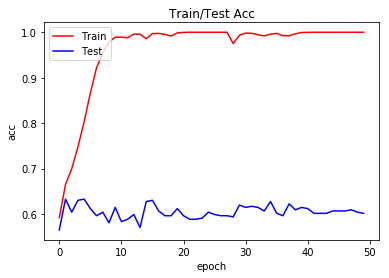

In [42]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc_list, color='red')
line2 = plt.plot(val_acc_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpgruacc.png')   # save the figure to file
plt.show()
plt.close()

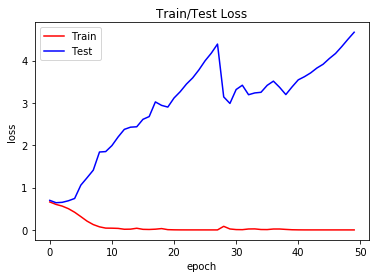

In [43]:
#plot train/val accuracies
plt.title("Train/Test Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
line1 = plt.plot(train_loss_list, color='red')
line2 = plt.plot(val_loss_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpgruloss.png')   # save the figure to file
plt.show()
plt.close()

In [44]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out_yc, trainds.fields['corpus'].vocab.vectors).to(device)
for i in m.parameters():
    print(i.shape)

torch.Size([12675, 100])
torch.Size([192, 100])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([192, 100])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([2, 256])
torch.Size([2])


In [45]:
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

train_acc_list, train_loss_list, val_acc_list, val_loss_list = fit_y(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=50)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50] train_loss: 0.6502, train_acc: 0.6243, val_loss: 0.6413, val_acc: 0.6328 


Epoch [2/50] train_loss: 0.5839, train_acc: 0.6913, val_loss: 0.6280, val_acc: 0.6484 


Epoch [3/50] train_loss: 0.5169, train_acc: 0.7351, val_loss: 0.6359, val_acc: 0.6380 


Epoch [4/50] train_loss: 0.4214, train_acc: 0.8168, val_loss: 0.6753, val_acc: 0.6250 


Epoch [5/50] train_loss: 0.3108, train_acc: 0.8800, val_loss: 0.6804, val_acc: 0.6510 


Epoch [6/50] train_loss: 0.1930, train_acc: 0.9522, val_loss: 0.8244, val_acc: 0.6172 


Epoch [7/50] train_loss: 0.1107, train_acc: 0.9788, val_loss: 0.9253, val_acc: 0.6354 


Epoch [8/50] train_loss: 0.0640, train_acc: 0.9907, val_loss: 1.0236, val_acc: 0.6354 


Epoch [9/50] train_loss: 0.0331, train_acc: 0.9957, val_loss: 1.1083, val_acc: 0.6719 


Epoch [10/50] train_loss: 0.0217, train_acc: 0.9977, val_loss: 1.2318, val_acc: 0.6354 


Epoch [11/50] train_loss: 0.0178, train_acc: 0.9983, val_loss: 1.3372, val_acc: 0.6354 


Epoch [12/50] train_loss: 0.0068, train_acc: 0.9997, val_loss: 1.4642, val_acc: 0.6354 


Epoch [13/50] train_loss: 0.0246, train_acc: 0.9928, val_loss: 1.4809, val_acc: 0.6302 


Epoch [14/50] train_loss: 0.0353, train_acc: 0.9901, val_loss: 1.3483, val_acc: 0.6615 


Epoch [15/50] train_loss: 0.0081, train_acc: 0.9997, val_loss: 1.4626, val_acc: 0.6432 


Epoch [16/50] train_loss: 0.0029, train_acc: 1.0000, val_loss: 1.5577, val_acc: 0.6484 


Epoch [17/50] train_loss: 0.0015, train_acc: 1.0000, val_loss: 1.6035, val_acc: 0.6354 


Epoch [18/50] train_loss: 0.0010, train_acc: 1.0000, val_loss: 1.6718, val_acc: 0.6484 


Epoch [19/50] train_loss: 0.0008, train_acc: 1.0000, val_loss: 1.7118, val_acc: 0.6667 


Epoch [20/50] train_loss: 0.0556, train_acc: 0.9820, val_loss: 1.6912, val_acc: 0.6432 


Epoch [21/50] train_loss: 0.0066, train_acc: 0.9997, val_loss: 1.6883, val_acc: 0.6302 


Epoch [22/50] train_loss: 0.0025, train_acc: 1.0000, val_loss: 1.7228, val_acc: 0.6354 


Epoch [23/50] train_loss: 0.0009, train_acc: 1.0000, val_loss: 1.7945, val_acc: 0.6484 


Epoch [24/50] train_loss: 0.0006, train_acc: 1.0000, val_loss: 1.8525, val_acc: 0.6536 


Epoch [25/50] train_loss: 0.0005, train_acc: 1.0000, val_loss: 1.9803, val_acc: 0.6224 


Epoch [26/50] train_loss: 0.0004, train_acc: 1.0000, val_loss: 2.0174, val_acc: 0.6510 


Epoch [27/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 2.1204, val_acc: 0.6615 


Epoch [28/50] train_loss: 0.0926, train_acc: 0.9670, val_loss: 2.1416, val_acc: 0.6068 


Epoch [29/50] train_loss: 0.0145, train_acc: 0.9965, val_loss: 1.9009, val_acc: 0.6406 


Epoch [30/50] train_loss: 0.0022, train_acc: 1.0000, val_loss: 1.9597, val_acc: 0.6224 


Epoch [31/50] train_loss: 0.0011, train_acc: 1.0000, val_loss: 1.9684, val_acc: 0.6302 


Epoch [32/50] train_loss: 0.0008, train_acc: 1.0000, val_loss: 2.0232, val_acc: 0.6328 


Epoch [33/50] train_loss: 0.0005, train_acc: 1.0000, val_loss: 2.0849, val_acc: 0.6406 


Epoch [34/50] train_loss: 0.0004, train_acc: 1.0000, val_loss: 2.2117, val_acc: 0.6536 


Epoch [35/50] train_loss: 0.0562, train_acc: 0.9806, val_loss: 2.0561, val_acc: 0.6328 


Epoch [36/50] train_loss: 0.0115, train_acc: 0.9971, val_loss: 2.2519, val_acc: 0.6562 


Epoch [37/50] train_loss: 0.0026, train_acc: 1.0000, val_loss: 2.1266, val_acc: 0.6458 


Epoch [38/50] train_loss: 0.0008, train_acc: 1.0000, val_loss: 2.2046, val_acc: 0.6432 


Epoch [39/50] train_loss: 0.0005, train_acc: 1.0000, val_loss: 2.1945, val_acc: 0.6458 


Epoch [40/50] train_loss: 0.0003, train_acc: 1.0000, val_loss: 2.2655, val_acc: 0.6432 


Epoch [41/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 2.3017, val_acc: 0.6484 


Epoch [42/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 2.3611, val_acc: 0.6484 


Epoch [43/50] train_loss: 0.0489, train_acc: 0.9800, val_loss: 2.0752, val_acc: 0.6380 


Epoch [44/50] train_loss: 0.0187, train_acc: 0.9945, val_loss: 2.1424, val_acc: 0.6094 


Epoch [45/50] train_loss: 0.0053, train_acc: 0.9988, val_loss: 2.0824, val_acc: 0.6224 


Epoch [46/50] train_loss: 0.0021, train_acc: 0.9997, val_loss: 2.0794, val_acc: 0.6432 


Epoch [47/50] train_loss: 0.0007, train_acc: 1.0000, val_loss: 2.1996, val_acc: 0.6354 


Epoch [48/50] train_loss: 0.0003, train_acc: 1.0000, val_loss: 2.2230, val_acc: 0.6302 


Epoch [49/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 2.2697, val_acc: 0.6354 


Epoch [50/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 2.3049, val_acc: 0.6328 



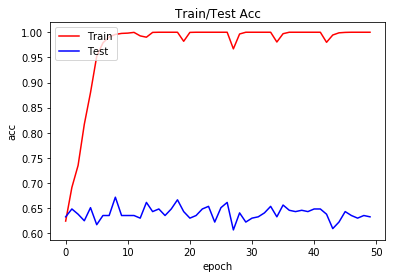

In [46]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc_list, color='red')
line2 = plt.plot(val_acc_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpcpgruacc.png')   # save the figure to file
plt.show()
plt.close()

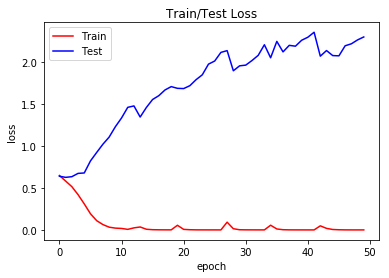

In [47]:
#plot train/val accuracies
plt.title("Train/Test Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
line1 = plt.plot(train_loss_list, color='red')
line2 = plt.plot(val_loss_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpcpgruloss.png')   # save the figure to file
plt.show()
plt.close()

In [48]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out_yf, trainds.fields['corpus'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

train_acc_list, train_loss_list, val_acc_list, val_loss_list = fit_z(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=50)

Epoch [1/50] train_loss: 1.0117, train_acc: 0.5736, val_loss: 1.0914, val_acc: 0.5339 


Epoch [2/50] train_loss: 0.8915, train_acc: 0.6310, val_loss: 1.3650, val_acc: 0.3776 


Epoch [3/50] train_loss: 0.8257, train_acc: 0.6646, val_loss: 1.3535, val_acc: 0.5339 


Epoch [4/50] train_loss: 0.7506, train_acc: 0.7035, val_loss: 1.5039, val_acc: 0.4766 


Epoch [5/50] train_loss: 0.6567, train_acc: 0.7458, val_loss: 1.3990, val_acc: 0.4766 


Epoch [6/50] train_loss: 0.5454, train_acc: 0.7872, val_loss: 2.1680, val_acc: 0.4557 


Epoch [7/50] train_loss: 0.4254, train_acc: 0.8475, val_loss: 1.9948, val_acc: 0.3958 


Epoch [8/50] train_loss: 0.3050, train_acc: 0.8997, val_loss: 1.6962, val_acc: 0.5339 


Epoch [9/50] train_loss: 0.2102, train_acc: 0.9374, val_loss: 2.5886, val_acc: 0.4557 


Epoch [10/50] train_loss: 0.1413, train_acc: 0.9594, val_loss: 2.6334, val_acc: 0.5339 


Epoch [11/50] train_loss: 0.0983, train_acc: 0.9745, val_loss: 4.8028, val_acc: 0.4766 


Epoch [12/50] train_loss: 0.0594, train_acc: 0.9875, val_loss: 3.4769, val_acc: 0.3984 


Epoch [13/50] train_loss: 0.0459, train_acc: 0.9890, val_loss: 4.1724, val_acc: 0.4766 


Epoch [14/50] train_loss: 0.0300, train_acc: 0.9933, val_loss: 5.0039, val_acc: 0.3984 


Epoch [15/50] train_loss: 0.0246, train_acc: 0.9968, val_loss: 8.1247, val_acc: 0.3984 


Epoch [16/50] train_loss: 0.0492, train_acc: 0.9846, val_loss: 8.9455, val_acc: 0.3984 


Epoch [17/50] train_loss: 0.0252, train_acc: 0.9925, val_loss: 6.8842, val_acc: 0.3646 


Epoch [18/50] train_loss: 0.0331, train_acc: 0.9890, val_loss: 6.7863, val_acc: 0.3646 


Epoch [19/50] train_loss: 0.0268, train_acc: 0.9930, val_loss: 6.1330, val_acc: 0.3125 


Epoch [20/50] train_loss: 0.0068, train_acc: 0.9988, val_loss: 10.8108, val_acc: 0.3177 


Epoch [21/50] train_loss: 0.0031, train_acc: 0.9997, val_loss: 11.3236, val_acc: 0.2292 


Epoch [22/50] train_loss: 0.0563, train_acc: 0.9846, val_loss: 5.5481, val_acc: 0.4557 


Epoch [23/50] train_loss: 0.0228, train_acc: 0.9954, val_loss: 7.6522, val_acc: 0.4531 


Epoch [24/50] train_loss: 0.0133, train_acc: 0.9974, val_loss: 5.9308, val_acc: 0.4557 


Epoch [25/50] train_loss: 0.0332, train_acc: 0.9907, val_loss: 11.8836, val_acc: 0.2422 


Epoch [26/50] train_loss: 0.0264, train_acc: 0.9916, val_loss: 5.3549, val_acc: 0.4766 


Epoch [27/50] train_loss: 0.0257, train_acc: 0.9916, val_loss: 9.5176, val_acc: 0.3177 


Epoch [28/50] train_loss: 0.0047, train_acc: 0.9997, val_loss: 5.8916, val_acc: 0.5339 


Epoch [29/50] train_loss: 0.0016, train_acc: 1.0000, val_loss: 4.5166, val_acc: 0.4531 


Epoch [30/50] train_loss: 0.0009, train_acc: 1.0000, val_loss: 8.7221, val_acc: 0.3125 


Epoch [31/50] train_loss: 0.0006, train_acc: 1.0000, val_loss: 11.4765, val_acc: 0.3958 


Epoch [32/50] train_loss: 0.0004, train_acc: 1.0000, val_loss: 10.1216, val_acc: 0.4531 


Epoch [33/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 5.1520, val_acc: 0.5339 


Epoch [34/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 10.2383, val_acc: 0.4766 


Epoch [35/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 8.5179, val_acc: 0.3958 


Epoch [36/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 11.0791, val_acc: 0.4531 


Epoch [37/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 11.7934, val_acc: 0.3203 


Epoch [38/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 9.6716, val_acc: 0.4531 


Epoch [39/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 10.8613, val_acc: 0.5339 


Epoch [40/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 14.4955, val_acc: 0.2969 


Epoch [41/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 12.6257, val_acc: 0.3229 


Epoch [42/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 10.5446, val_acc: 0.5339 


Epoch [43/50] train_loss: 0.0310, train_acc: 0.9939, val_loss: 8.9158, val_acc: 0.5339 


Epoch [44/50] train_loss: 0.1312, train_acc: 0.9693, val_loss: 6.5177, val_acc: 0.4557 


Epoch [45/50] train_loss: 0.0156, train_acc: 0.9942, val_loss: 8.2264, val_acc: 0.3958 


Epoch [46/50] train_loss: 0.0019, train_acc: 1.0000, val_loss: 9.5426, val_acc: 0.4766 


Epoch [47/50] train_loss: 0.0261, train_acc: 0.9919, val_loss: 6.1342, val_acc: 0.3932 


Epoch [48/50] train_loss: 0.0240, train_acc: 0.9916, val_loss: 11.8790, val_acc: 0.3958 


Epoch [49/50] train_loss: 0.0158, train_acc: 0.9936, val_loss: 5.7352, val_acc: 0.4766 


Epoch [50/50] train_loss: 0.0109, train_acc: 0.9962, val_loss: 9.2197, val_acc: 0.2292 



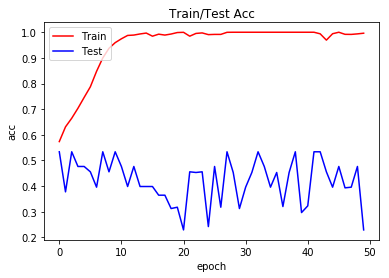

In [49]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc_list, color='red')
line2 = plt.plot(val_acc_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpgru11acc.png')   # save the figure to file
plt.show()
plt.close()

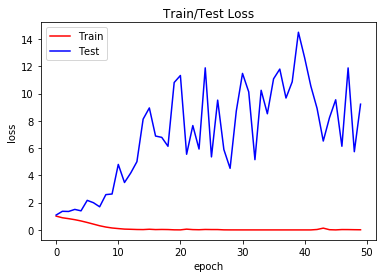

In [50]:
#plot train/val accuracies
plt.title("Train/Test Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
line1 = plt.plot(train_loss_list, color='red')
line2 = plt.plot(val_loss_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpgru11loss.png')   # save the figure to file
plt.show()
plt.close()

In [51]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out_yf, trainds.fields['corpus'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

train_acc_list, train_loss_list, val_acc_list, val_loss_list = fit_z(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=50)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50] train_loss: 0.9832, train_acc: 0.5762, val_loss: 1.5666, val_acc: 0.3984 


Epoch [2/50] train_loss: 0.8629, train_acc: 0.6461, val_loss: 1.2261, val_acc: 0.4557 


Epoch [3/50] train_loss: 0.7693, train_acc: 0.6925, val_loss: 1.1861, val_acc: 0.4766 


Epoch [4/50] train_loss: 0.6577, train_acc: 0.7528, val_loss: 1.2949, val_acc: 0.5339 


Epoch [5/50] train_loss: 0.5383, train_acc: 0.8020, val_loss: 2.0979, val_acc: 0.3177 


Epoch [6/50] train_loss: 0.3973, train_acc: 0.8641, val_loss: 2.0772, val_acc: 0.3646 


Epoch [7/50] train_loss: 0.2801, train_acc: 0.9186, val_loss: 1.6306, val_acc: 0.5339 


Epoch [8/50] train_loss: 0.1797, train_acc: 0.9545, val_loss: 2.9651, val_acc: 0.3906 


Epoch [9/50] train_loss: 0.1122, train_acc: 0.9771, val_loss: 3.7788, val_acc: 0.3958 


Epoch [10/50] train_loss: 0.0645, train_acc: 0.9910, val_loss: 4.8447, val_acc: 0.2083 


Epoch [11/50] train_loss: 0.0415, train_acc: 0.9945, val_loss: 3.2114, val_acc: 0.3568 


Epoch [12/50] train_loss: 0.0275, train_acc: 0.9977, val_loss: 4.8484, val_acc: 0.2292 


Epoch [13/50] train_loss: 0.0290, train_acc: 0.9945, val_loss: 3.0520, val_acc: 0.5339 


Epoch [14/50] train_loss: 0.0189, train_acc: 0.9971, val_loss: 5.9416, val_acc: 0.2969 


Epoch [15/50] train_loss: 0.0143, train_acc: 0.9986, val_loss: 5.5198, val_acc: 0.5339 


Epoch [16/50] train_loss: 0.0304, train_acc: 0.9930, val_loss: 6.1019, val_acc: 0.3958 


Epoch [17/50] train_loss: 0.0215, train_acc: 0.9965, val_loss: 5.2242, val_acc: 0.2214 


Epoch [18/50] train_loss: 0.0079, train_acc: 0.9991, val_loss: 4.0185, val_acc: 0.4557 


Epoch [19/50] train_loss: 0.0067, train_acc: 0.9991, val_loss: 4.5125, val_acc: 0.3750 


Epoch [20/50] train_loss: 0.0025, train_acc: 1.0000, val_loss: 5.2269, val_acc: 0.4766 


Epoch [21/50] train_loss: 0.0010, train_acc: 1.0000, val_loss: 6.8899, val_acc: 0.2500 


Epoch [22/50] train_loss: 0.0008, train_acc: 1.0000, val_loss: 7.4466, val_acc: 0.3073 


Epoch [23/50] train_loss: 0.0581, train_acc: 0.9788, val_loss: 5.4911, val_acc: 0.4557 


Epoch [24/50] train_loss: 0.0179, train_acc: 0.9957, val_loss: 8.8981, val_acc: 0.3177 


Epoch [25/50] train_loss: 0.0061, train_acc: 0.9994, val_loss: 7.9844, val_acc: 0.3984 


Epoch [26/50] train_loss: 0.0016, train_acc: 1.0000, val_loss: 7.3755, val_acc: 0.1354 


Epoch [27/50] train_loss: 0.0010, train_acc: 1.0000, val_loss: 6.0156, val_acc: 0.3984 


Epoch [28/50] train_loss: 0.0011, train_acc: 1.0000, val_loss: 7.4895, val_acc: 0.5339 


Epoch [29/50] train_loss: 0.0005, train_acc: 1.0000, val_loss: 6.0426, val_acc: 0.5339 


Epoch [30/50] train_loss: 0.0287, train_acc: 0.9916, val_loss: 8.5361, val_acc: 0.3646 


Epoch [31/50] train_loss: 0.0390, train_acc: 0.9881, val_loss: 6.1827, val_acc: 0.3958 


Epoch [32/50] train_loss: 0.0072, train_acc: 0.9983, val_loss: 7.8732, val_acc: 0.2005 


Epoch [33/50] train_loss: 0.0024, train_acc: 1.0000, val_loss: 5.1694, val_acc: 0.3984 


Epoch [34/50] train_loss: 0.0009, train_acc: 1.0000, val_loss: 12.0770, val_acc: 0.1510 


Epoch [35/50] train_loss: 0.0225, train_acc: 0.9922, val_loss: 10.4647, val_acc: 0.3073 


Epoch [36/50] train_loss: 0.0140, train_acc: 0.9962, val_loss: 6.2939, val_acc: 0.3750 


Epoch [37/50] train_loss: 0.0035, train_acc: 0.9997, val_loss: 10.8525, val_acc: 0.2786 


Epoch [38/50] train_loss: 0.0010, train_acc: 1.0000, val_loss: 7.5397, val_acc: 0.2969 


Epoch [39/50] train_loss: 0.0006, train_acc: 1.0000, val_loss: 7.5248, val_acc: 0.3203 


Epoch [40/50] train_loss: 0.0107, train_acc: 0.9962, val_loss: 8.7623, val_acc: 0.3177 


Epoch [41/50] train_loss: 0.0310, train_acc: 0.9887, val_loss: 8.1792, val_acc: 0.2786 


Epoch [42/50] train_loss: 0.0055, train_acc: 0.9994, val_loss: 6.5269, val_acc: 0.4531 


Epoch [43/50] train_loss: 0.0009, train_acc: 1.0000, val_loss: 7.1139, val_acc: 0.4531 


Epoch [44/50] train_loss: 0.0006, train_acc: 1.0000, val_loss: 6.9886, val_acc: 0.4557 


Epoch [45/50] train_loss: 0.0004, train_acc: 1.0000, val_loss: 8.5625, val_acc: 0.4766 


Epoch [46/50] train_loss: 0.0003, train_acc: 1.0000, val_loss: 9.2696, val_acc: 0.4766 


Epoch [47/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 12.9079, val_acc: 0.2214 


Epoch [48/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 11.4336, val_acc: 0.2552 


Epoch [49/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 8.8990, val_acc: 0.3203 


Epoch [50/50] train_loss: 0.0303, train_acc: 0.9910, val_loss: 13.8131, val_acc: 0.2214 



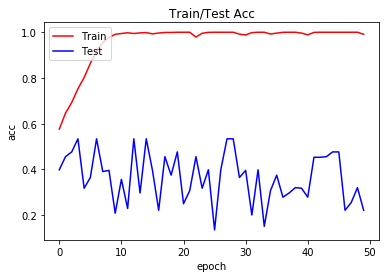

In [52]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc_list, color='red')
line2 = plt.plot(val_acc_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpcpgrul1acc.png')   # save the figure to file
plt.show()
plt.close()

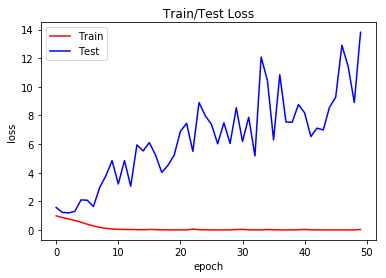

In [53]:
#plot train/val accuracies
plt.title("Train/Test Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
line1 = plt.plot(train_loss_list, color='red')
line2 = plt.plot(val_loss_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpcpgrul1loss.png')   # save the figure to file
plt.show()
plt.close()